# Mount Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Set Environment and Load Libraries

In [5]:
%cd {'drive/MyDrive/DJIA'}

/content/drive/MyDrive/DJIA


In [28]:
import warnings
warnings.filterwarnings("ignore")

# save models
import joblib

# numeric manipuation
import pandas as pd
import numpy as np
from tqdm import tqdm
from pathlib import Path

# plots
import matplotlib.pyplot as plt

# basic models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier

# ensemble models
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier

# feature selection
from sklearn.feature_selection import SelectKBest

from sklearn.pipeline import Pipeline

# model selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# ensemble of best performing models
from sklearn.ensemble import VotingClassifier

# metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

To avoid data leakage during cv, we will use sliding window split.

In [13]:
from src.ts_utils.rnn import SlidingWindowSplit

###### Hiperparameter optimization libraries install and import

In [29]:
!pip install -q optuna
import optuna

     |████████████████████████████████| 308 kB 5.2 MB/s 
     |████████████████████████████████| 209 kB 55.0 MB/s 
     |████████████████████████████████| 80 kB 6.7 MB/s 
     |████████████████████████████████| 75 kB 3.7 MB/s 
     |████████████████████████████████| 49 kB 5.4 MB/s 
     |████████████████████████████████| 112 kB 54.9 MB/s 
     |████████████████████████████████| 149 kB 64.1 MB/s 


In [33]:
!pip install -q scikit-optimize
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

     |████████████████████████████████| 100 kB 3.1 MB/s 


## Set results path

In [15]:
results_path = Path('results', 'classic_models')
if not results_path.exists():
    results_path.mkdir(parents=True)

# Load Data

In [14]:
!pip install --upgrade -q tables
data = pd.read_hdf('data/ts_cl.h5', 'all_features')

In [17]:
# avoid sklearn future warning
data.columns = data.columns.astype(str)
data.drop('fwd_returns', axis=1, inplace=True)

In [18]:
cv_data = data.loc[:'2016-03']

In [19]:
def split_data(data, train_indices, test_indices):
    X = data.drop(['Label'], axis=1)
    y = data.Label
    X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
    y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]
    return (X_train, X_test, y_train, y_test)

# Test multiple classic models

In [34]:
num_folds = 10

models = []
# basic models
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(probability=True)))

# ensemble models
models.append(('XGB', XGBClassifier(eval_metric='logloss')))
models.append(('LGBM', LGBMClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('ADA', AdaBoostClassifier()))
models.append(('ET', ExtraTreesClassifier()))

# KFolds for model selection:
results, names = [], []
for name, model in models:
    tscv = SlidingWindowSplit(n_splits=num_folds)
    split = tscv.split(cv_data, fixed_length=True, train_splits=2, test_splits=1)
    cv_results = []
    for train_indices, test_indices in split:
        X_train, X_test, y_train, y_test = split_data(cv_data, train_indices, test_indices)
        clf = model.fit(X_train.values, y_train.values)
        cv_results.append(roc_auc_score(y_test.values, clf.predict_proba(X_test.values)[:,1]))
    results.append(cv_results)
    names.append(name)
    print("Model: {:>4} Mean: {:>8} Std: {:>8}".format(name, np.mean(cv_results), np.std(cv_results)))

Model:   LR Mean: 0.5167951995531319 Std: 0.03193847367053302
Model:  LDA Mean: 0.5082359191879795 Std: 0.04279599476110318
Model:  KNN Mean: 0.4687696067020175 Std: 0.048529593127052024
Model: CART Mean: 0.5227884342537437 Std: 0.021923611899754926
Model:   NB Mean: 0.5258903919924274 Std: 0.031844455170212234
Model:  SVM Mean: 0.5034754957063223 Std: 0.04200884021113259
Model:  XGB Mean: 0.5655684900189196 Std: 0.0573040459724295
Model: LGBM Mean: 0.5655501882361924 Std: 0.0373802256767226
Model:   RF Mean: 0.539671694715243 Std: 0.02901519199693346
Model:  ADA Mean: 0.5253931106194273 Std: 0.03949560502151868
Model:   ET Mean: 0.5296345972537846 Std: 0.03534152430776792



We see that the best performing models get to up to 56.5 AUC, which is pretty impressive. Hence, we will try to tweak a bit those models in order to hopefully achieve a slightly better AUC. Finally, we will build an ensemble with these 3. The best model could be considered to be LGBM, since accomplishes great performance and has the least variance among the top three. We will use LGBM to get the best K-features and get the importance of parameters.

# Feature Importance

In order to check the feature importance, we will use `LGBMClassifier` since it is the one that has performed the best among all.

In [35]:
lgbm_clf = LGBMClassifier()

lgbm_clf.fit(X_train, y_train)

LGBMClassifier()

In [36]:
# wrap function for plot_importance to add figsize to xgb.plot_importance
def lgbm_plot_importance(booster, figsize, **kwargs): 
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return lgb.plot_importance(booster=booster, ax=ax, **kwargs)

## Weight Importance

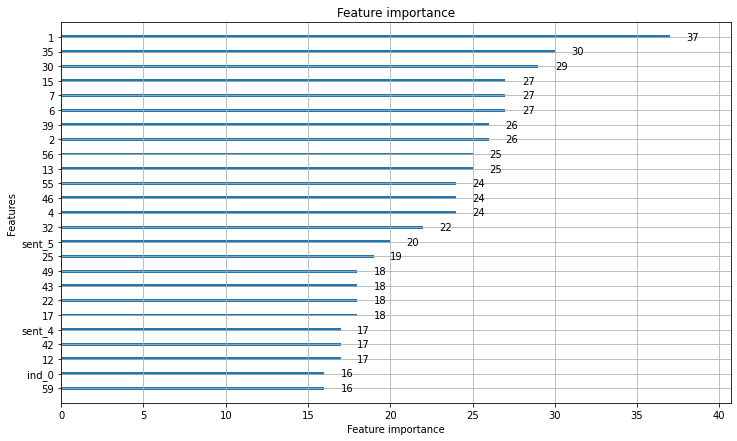

In [37]:
lgbm_plot_importance(lgbm_clf, figsize=(12, 7), max_num_features=25);


Last day returns are the most important, followed by about one month back returns. We see some sentiments and one indicator in the top 25 features.

## Accuracy Importance (gain)

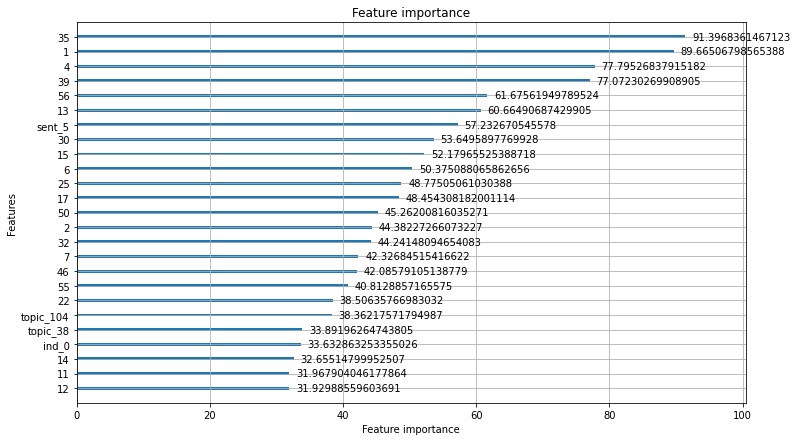

In [38]:
lgbm_plot_importance(lgbm_clf, figsize=(12, 7), max_num_features=25, importance_type='gain');

We see some topics in the top 25 important features. 35 day back returns give the greatest gain.

## K-Best Features

In [41]:
def get_train_test(cv_data):
    train_data_len = int(len(cv_data)*0.8)
    X = cv_data.drop(['Label'], axis=1)
    y = cv_data.Label

    X_train = X.iloc[:train_data_len]
    y_train = y.iloc[:train_data_len]

    X_test = X.iloc[train_data_len:]
    y_test = y.iloc[train_data_len:]
    return (X_train, X_test, y_train, y_test)

In [42]:
model = LGBMClassifier()


fs = SelectKBest()  # f-classif by default
pipeline = Pipeline(steps=[('sel',fs), ('LGBM', model)])

tscv = SlidingWindowSplit(n_splits=10)

# cv = KFold(n_splits=2, random_state=743, shuffle=True)

# define the grid
grid = dict()
grid['sel__k'] = [i for i in range(1, X_train.shape[1])]

# define the grid search
search = GridSearchCV(pipeline, grid, scoring='roc_auc', n_jobs=-1, cv=tscv, verbose=1)
# perform the search
X_train, X_test, y_train, y_test = get_train_test(cv_data)
results = search.fit(X_train, y_train)

# summarize best
print('Best AUC: %.3f' % results.best_score_)
print('Best Config: %s' % results.best_params_)

# summarize all
means = results.cv_results_['mean_test_score']
params = results.cv_results_['params']
for mean, param in zip(means, params):
    print(">%.3f with: %r" % (mean, param))


Fitting 10 folds for each of 230 candidates, totalling 2300 fits
Best AUC: 0.563
Best Config: {'sel__k': 230}
>0.520 with: {'sel__k': 1}
>0.519 with: {'sel__k': 2}
>0.507 with: {'sel__k': 3}
>0.512 with: {'sel__k': 4}
>0.497 with: {'sel__k': 5}
>0.490 with: {'sel__k': 6}
>0.484 with: {'sel__k': 7}
>0.483 with: {'sel__k': 8}
>0.498 with: {'sel__k': 9}
>0.487 with: {'sel__k': 10}
>0.488 with: {'sel__k': 11}
>0.499 with: {'sel__k': 12}
>0.494 with: {'sel__k': 13}
>0.490 with: {'sel__k': 14}
>0.496 with: {'sel__k': 15}
>0.484 with: {'sel__k': 16}
>0.498 with: {'sel__k': 17}
>0.497 with: {'sel__k': 18}
>0.493 with: {'sel__k': 19}
>0.493 with: {'sel__k': 20}
>0.502 with: {'sel__k': 21}
>0.502 with: {'sel__k': 22}
>0.497 with: {'sel__k': 23}
>0.502 with: {'sel__k': 24}
>0.513 with: {'sel__k': 25}
>0.496 with: {'sel__k': 26}
>0.494 with: {'sel__k': 27}
>0.497 with: {'sel__k': 28}
>0.489 with: {'sel__k': 29}
>0.500 with: {'sel__k': 30}
>0.500 with: {'sel__k': 31}
>0.504 with: {'sel__k': 32}
>0.

In [55]:
selector = SelectKBest(k=results.best_params_['sel__k'])
selector.fit(X_train, y_train)
kbestcols = selector.get_support(indices=True)

In [91]:
def run_cv(lgbm_cv_data, model=LGBMClassifier(), soft=True):
    if 'Label' not in lgbm_cv_data.columns:
        lgbm_cv_data['Label'] = cv_data['Label']

    tscv = SlidingWindowSplit(n_splits=5)
    split = tscv.split(lgbm_cv_data, fixed_length=True, train_splits=2, test_splits=1)
    roc_auc_model = []

    for train_indices, test_indices in split:
        X_train, X_test, y_train, y_test = split_data(lgbm_cv_data, train_indices, test_indices)
        clf = model.fit(X_train, y_train)
        if soft:
            preds = clf.predict_proba(X_test)[:,1]    
            roc_auc_model.append(roc_auc_score(y_test, preds))
        else:
            preds = clf.predict(X_test)
            roc_auc_model.append(roc_auc_score(y_test, preds))
    cv_results = roc_auc_model
    print(roc_auc_model)
    print("AUC: Mean: {:>8} Std: {:>8}".format(np.mean(cv_results), np.std(cv_results)))

# Hyperparameter tuning

## LGBM Optimization (OPTUNA)

In order to optimize LGBM, we will make use of OPTUNA optimizer, to perform bayesian optimizaiton of parameters. We will use the sliding Window CV to search them.

In [57]:
def objective(trial, cv_data):
    # define a param grid to search for optimal LGBM parameters
    param_grid = {
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.95, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.95, step=0.1
        ),
        "metric" : "auc",
        'verbose' : -1,
        'n_jobs':-1
    }

    lgbm_cv_data = cv_data.iloc[kbestcols]

    if 'Label' not in lgbm_cv_data.columns:
        lgbm_cv_data['Label'] = cv_data['Label']
    
    # set sliding window time series split for cv
    tscv = SlidingWindowSplit(n_splits=8)
    split = tscv.split(lgbm_cv_data, fixed_length=True,train_splits=2, test_splits=1)

    cv_scores = []
    model = lgb.LGBMClassifier(**param_grid)

    # iterate over the splits of the sliding window
    for idx, (train_indices, test_indices) in enumerate(split):
        # get train and test splits
        X_train, X_test, y_train, y_test = split_data(lgbm_cv_data, train_indices, test_indices)    
        model.fit(
            X_train,
            y_train.values,
            eval_set=[(X_test, y_test.values)],
            eval_metric="val_auc",
            early_stopping_rounds=3000,
            verbose=-1
        )
        preds = model.predict_proba(X_test, verbose=-1)
        cv_scores.append(roc_auc_score(y_test, preds[:, 1]))
    return np.mean(cv_scores)

In [ ]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    study = optuna.create_study(direction="maximize", study_name="LGBM Classifier")
    func = lambda trial: objective(trial, cv_data)
    study.optimize(func, n_trials=200, show_progress_bar=True)

In [59]:
print(f"\tBest value (auc): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (auc): 0.68623
	Best params:
		n_estimators: 10000
		learning_rate: 0.08446771850205366
		num_leaves: 2320
		lambda_l1: 0
		lambda_l2: 10
		bagging_fraction: 0.9
		bagging_freq: 1
		feature_fraction: 0.8


In [109]:
study.trials_dataframe().sort_values(by='value', ascending=False).head()

,number,value,datetime_start,datetime_complete,duration,params_bagging_fraction,params_bagging_freq,params_feature_fraction,params_lambda_l1,params_lambda_l2,params_learning_rate,params_n_estimators,params_num_leaves,state
86,86,0.686232,2022-01-08 18:48:18.180324,2022-01-08 18:48:23.314222,0 days 00:00:05.133898,0.9,1,0.8,0,10,0.084468,10000,2320,COMPLETE
147,147,0.686232,2022-01-08 18:51:33.644700,2022-01-08 18:51:37.551526,0 days 00:00:03.906826,0.9,1,0.8,0,10,0.089661,10000,1540,COMPLETE
180,180,0.686232,2022-01-08 18:53:20.998481,2022-01-08 18:53:25.057207,0 days 00:00:04.058726,0.9,1,0.8,0,10,0.089743,10000,1620,COMPLETE
95,95,0.686220,2022-01-08 18:48:52.476293,2022-01-08 18:48:57.827342,0 days 00:00:05.351049,0.9,1,0.8,0,5,0.055649,10000,2440,COMPLETE
142,142,0.685316,2022-01-08 18:51:17.443641,2022-01-08 18:51:21.317531,0 days 00:00:03.873890,0.9,1,0.8,0,10,0.088856,10000,1420,COMPLETE


In [61]:
lgb_params_optuna = study.best_params

In [62]:
lgbm_opt = LGBMClassifier(**lgb_params_optuna)
lgbm_opt.set_params(verbosity=-1)

LGBMClassifier(bagging_fraction=0.9, bagging_freq=1, feature_fraction=0.8,
               lambda_l1=0, lambda_l2=10, learning_rate=0.08446771850205366,
               n_estimators=10000, num_leaves=2320, verbosity=-1)

Save lgbm model.

In [70]:
joblib.dump(lgbm_opt, (results_path / 'LGBM_OPTUNA_cv.joblib').as_posix())

['results/classic_models/LGBM_OPTUNA_cv.joblib']

## Random Forest Optimization (Skopt)

Set Bayesian Optimization for Random Forest with sliding window cv.

In [64]:
tscv = SlidingWindowSplit(n_splits=5)
searchcv = BayesSearchCV(
    RandomForestClassifier(),
    search_spaces={
        'n_estimators':Integer(20, 1000),
        'warm_start':Categorical([True, False]),
        'ccp_alpha':Real(0.0, 1.0)
    },
    cv=tscv,
    verbose=1,
    n_iter=50
)

In [65]:
searchcv.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


BayesSearchCV(cv=SlidingWindowSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
              estimator=RandomForestClassifier(),
              search_spaces={'ccp_alpha': Real(low=0.0, high=1.0, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=20, high=1000, prior='uniform', transform='normalize'),
                             'warm_start': Categorical(categories=(True, False), prior=None)},
              verbose=1)

In [66]:
print("val. score: %s" % searchcv.best_score_)
print("test score: %s" % searchcv.score(X_test, y_test))
print("best params: %s" % str(searchcv.best_params_))

val. score: 0.5524193548387097
test score: 0.5067024128686327
best params: OrderedDict([('ccp_alpha', 0.020916053757824352), ('n_estimators', 911), ('warm_start', False)])


In [67]:
model = RandomForestClassifier(**searchcv.best_params_)

Save random forest model.

In [68]:
joblib.dump(model, (results_path / 'RF_BAYES_OPT.joblib').as_posix())

['results/classic_models/RF_BAYES_OPT.joblib']

## Analize CV performance of tuned models

### Test Optuna LGBM

In [71]:
kcols_cv_data = cv_data.iloc[kbestcols]
lgbm = joblib.load((results_path/'LGBM_OPTUNA_cv.joblib').as_posix())
run_cv(kcols_cv_data, lgbm)

[0.7843137254901961, 0.39204545454545453, 0.6335227272727273, 0.46111111111111114]
AUC: Mean: 0.5677482546048722 Std: 0.1528641870711917


Lots of varaince in the predictions.

### Test Skopt RF

In [74]:
lgbm_cv_data = cv_data
rf = joblib.load((results_path/'RF_BAYES_OPT.joblib').as_posix())
run_cv(kcols_cv_data, rf)

[0.6778711484593838, 0.37784090909090906, 0.48579545454545453, 0.5666666666666667]
AUC: Mean: 0.5270435446906034 Std: 0.1098655874970408


Relatively high variance in the predictions

### XGB Base model

In [75]:
xgb_clf = XGBClassifier()
xgb_clf.fit(X_train, y_train)
run_cv(kcols_cv_data, xgb_clf)

[0.7170868347338936, 0.4545454545454546, 0.5170454545454546, 0.5694444444444444]
AUC: Mean: 0.5645305470673119 Std: 0.09701690816926278


Lowest varaince of all.

We see the first fold performs best, the second one, all fail, the third one, lgbm outperforms the rest, the last one, rf and xgb get past 56 AUC.

# Build ensemble of Tuned Models

### Soft Voting Classifier

In [101]:
voting_clf_soft = VotingClassifier(estimators=[
                    ('lgbm', lgbm),                                 # optimized LGBM
                    ('xgb', XGBClassifier(eval_metric='logloss')),  # XGBoost
                    ('rf', rf)                                      # RF optimized
                    ], voting='soft')

In [82]:
run_cv(kcols_cv_data, model=voting_clf_soft)

[0.7843137254901961, 0.4005681818181818, 0.5568181818181819, 0.5222222222222223]
AUC: Mean: 0.5659805778371955 Std: 0.13877082484059253


High variance still, almost the same mean as lgbm.

In [102]:
voting_clf_soft.fit(X_train, y_train)
preds = voting_clf.predict(X_test)
roc_auc_score(y_test, preds)

0.5447866344605475

In [103]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.56      0.39      0.46       184
           1       0.54      0.70      0.61       189

    accuracy                           0.55       373
   macro avg       0.55      0.54      0.53       373
weighted avg       0.55      0.55      0.54       373



Greater recall and f1-score when market goes up vs when it goes down.

In [108]:
joblib.dump(voting_clf_soft, (results_path / 'SOFT_VOTING.joblib').as_posix())

['results/classic_models/SOFT_VOTING.joblib']

### Hard voting Classifier

In [104]:
voting_clf_hard = VotingClassifier(estimators=[
                    ('lgbm', lgbm),                                 # optimized LGBM
                    ('xgb', XGBClassifier(eval_metric='logloss')),  # XGBoost
                    ('rf', rf)                                      # RF optimized
                    ], voting='hard')

In [92]:
run_cv(kcols_cv_data, model=voting_clf_hard, soft=False)

[0.7044817927170868, 0.5198863636363636, 0.5028409090909091, 0.6027777777777777]
AUC: Mean: 0.5824967108055343 Std: 0.07993244680032095


Half the variance, and greatest mean AUC in cv. Always above 50%.

In [105]:
voting_clf_hard.fit(X_train, y_train)
preds = voting_clf.predict(X_test)
roc_auc_score(y_test, preds)

0.5447866344605475

In [106]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.56      0.39      0.46       184
           1       0.54      0.70      0.61       189

    accuracy                           0.55       373
   macro avg       0.55      0.54      0.53       373
weighted avg       0.55      0.55      0.54       373



Model has better recall when market goes up than when it goes up.

Save hard voting classifier.

In [107]:
joblib.dump(voting_clf_hard, (results_path / 'HARD_VOTING.joblib').as_posix())

['results/classic_models/HARD_VOTING.joblib']